[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/DIEN/DIEN.ipynb)

> This notebook runs DIEN on MovieLens1M dataset. We'll use YouTubeDNN for generating candidates and DIEN for ranking these candidates.

> Only movies with ratings larger than 3 are treated as 'positive' samples for each user. Every last 10 'positive' movies of each user are held out for testing.

**Download dataset and install packages**

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git
! cd HandyRec && python setup.py install
! pip install faiss-gpu

Cloning into 'HandyRec'...
remote: Enumerating objects: 2109, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 2109 (delta 137), reused 200 (delta 88), pack-reused 1803
Receiving objects: 100% (2109/2109), 24.55 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (891/891), done.
running install
running bdist_egg
running egg_info
creating handyrec.egg-info
writing handyrec.egg-info/PKG-INFO
writing dependency_links to handyrec.egg-info/dependency_links.txt
writing requirements to handyrec.egg-info/requires.txt
writing top-level names to handyrec.egg-info/top_level.txt
writing manifest file 'handyrec.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'handyrec.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/handyrec
copying handyrec/config.py -> build/lib/handyrec
copying handyrec/

In [1]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
! unzip -o ml-1m.zip

--2022-05-25 00:34:56--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  6.96MB/s    in 0.8s    

2022-05-25 00:34:58 (6.96 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


**Import relative packages**

In [9]:
from handyrec.data.movielens import MovielensDataHelper
from handyrec.data.utils import gen_sequence
from handyrec.data import SequenceWiseDataset

from handyrec.models.ranking import DIEN
from handyrec.config import ConfigLoader
from handyrec.data.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import gc

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
BATCH_SIZE = 2**12
NEPOCH = 50

TEST_NUM = 10
VALID_RATIO = 0.1
NEG_NUM = 10

***Note:*** DIEN requires a SequenceWiseDataset dataset as input, which consumes much more memory than other types of datasets as it has both negative samples and negative sequences. If the notebook crashed, please consider lowering the values of `SEQ_LEN` and `NEG_NUM`.

**Load MovieLens1M data**

In [12]:
retrieve_dh = MovielensDataHelper('./ml-1m/')
data = retrieve_dh.get_clean_data(sparse_features=['gender','occupation','zip','age','year'])
data['inter']['hist_movie'] = gen_sequence(data['inter'], 'user_id', 'movie_id', seq_len=15)

Generate movie_id sequence: 100%|██████████| 6040/6040 [00:04<00:00, 1445.73it/s]


## Prepare data for ranking

In [13]:
# * Use pre-trained embeddings and Faiss to generate candidates
user_embs = np.load("./HandyRec/examples/DSSM/DSSM_user_embd.npy")
item_embs = np.load("./HandyRec/examples/DSSM/DSSM_item_embd.npy")
user_ids = np.load("./HandyRec/examples/DSSM/user_ids.npy")

test_candidates = search_embedding(
    32, item_embs, user_embs, data["item"]["movie_id"].values, 100, gpu=True
)

test_candidates = {user_ids[i] : test_candidates[i] for i in range(len(user_ids))}

In [14]:
user_features = ['user_id']
item_features = ['movie_id', 'genres']
inter_features = ['hist_movie']

In [15]:
ranking_dataset = SequenceWiseDataset(
    "RankingDataset",
    task="ranking",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    label_name="label",
    seq_name="hist_movie",
    neg_seq_name="neg_hist_movie",
    threshold=4,
)

ranking_dataset.train_test_split(TEST_NUM)
ranking_dataset.negative_sampling(NEG_NUM)
ranking_dataset.train_valid_split(VALID_RATIO)
ranking_dataset.gen_dataset(user_features, item_features, inter_features, test_candidates)

Save inter features: 100%|██████████| 2/2 [00:19<00:00,  9.52s/it]


In [16]:
train_data, valid_data, test_data, test_label = ranking_dataset.load_dataset(
    user_features, item_features, inter_features, BATCH_SIZE*2
)

Load inter features: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


In [17]:
feature_dim = ranking_dataset.get_feature_dim(user_features, item_features, [])
feature_dim["genre_id"] = 19

## Train rank model and predict <a name="section-3"></a>

In [18]:
cfg = ConfigLoader("./HandyRec/examples/DIEN/DIEN_cfg.yaml")
feature_groups = cfg.prepare_features(feature_dim, data)

In [36]:
rank_model = DIEN(
    feature_groups["item_seq_feat_group"],
    feature_groups["neg_item_seq_feat_group"],
    feature_groups["other_feature_group"],
    **cfg.config.Model
)

In [37]:
rank_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=2e-4, clipvalue=1.), 
    loss=binary_crossentropy
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor="val_loss",
    mode='min',
    save_best_only=True
)
history = rank_model.fit(
    x=train_data, 
    validation_data=valid_data,
    epochs=NEPOCH,
    callbacks=[checkpoint]
)

Epoch 1/50
623/623 [==============================] - 133s 196ms/step - loss: 73.3111 - val_loss: 27.2014
Epoch 2/50
623/623 [==============================] - 117s 188ms/step - loss: 15.3058 - val_loss: 9.0745
Epoch 3/50
623/623 [==============================] - 118s 189ms/step - loss: 8.1417 - val_loss: 8.2548
Epoch 4/50
623/623 [==============================] - 118s 189ms/step - loss: 7.4248 - val_loss: 6.9569
Epoch 5/50
623/623 [==============================] - 118s 189ms/step - loss: 6.9930 - val_loss: 5.8209
Epoch 6/50
623/623 [==============================] - 119s 191ms/step - loss: 4.5556 - val_loss: 3.5181
Epoch 7/50
623/623 [==============================] - 118s 190ms/step - loss: 3.6825 - val_loss: 3.3308
Epoch 8/50
623/623 [==============================] - 118s 189ms/step - loss: 3.4069 - val_loss: 2.8313
Epoch 9/50
623/623 [==============================] - 122s 195ms/step - loss: 3.2274 - val_loss: 3.0051
Epoch 10/50
623/623 [==============================] - 118s 1

In [38]:
rank_model.load_weights('./rank_checkpoint/')
model = Model(inputs=rank_model.real_inputs, outputs=rank_model.outputs)

In [39]:
del train_data
gc.collect()

28468

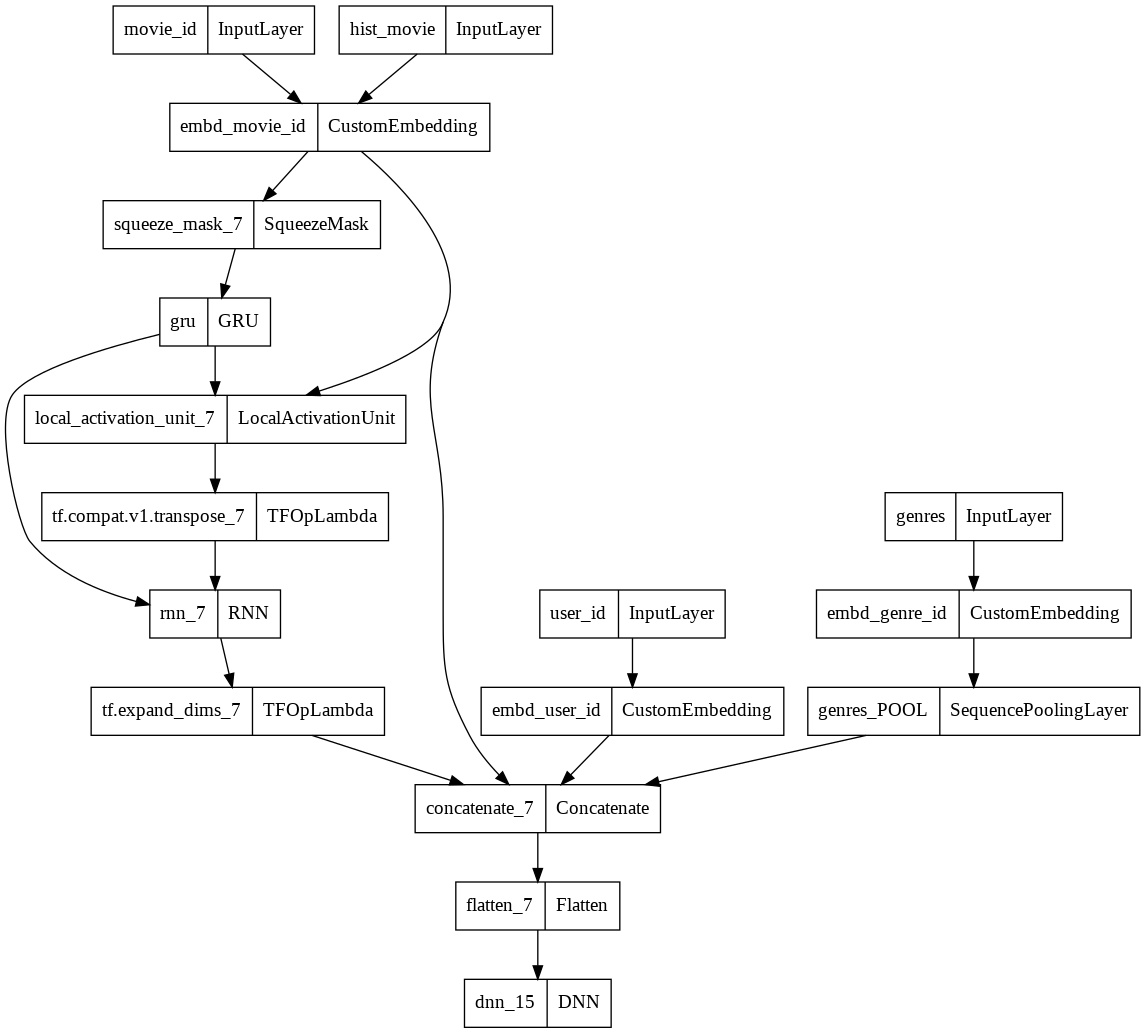

In [40]:
plot_model(model)

In [41]:
pred = model.predict(test_data, batch_size=BATCH_SIZE)

In [42]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = test_data['user_id']
pred_df['movie_id'] = test_data['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

In [43]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = pd.Series(test_data['user_id']).drop_duplicates()
test_label_df['label'] = test_label.tolist()

In [44]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [45]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.01241587140793624

In [46]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.03420563903427318

In [47]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.13670437278406214